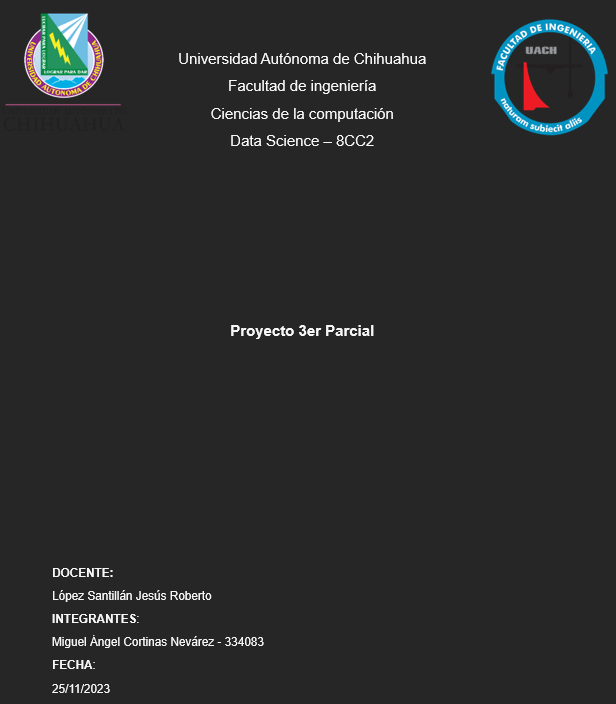

In [1]:
from tensorflow import keras

shakespeare_url = "https://homl.info/shakespeare" #shortcut URL
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
  shakespeare_text = f.read()

tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts([shakespeare_text])

1115394/1115394 [==============================] - 0s 0us/step


In [2]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [3]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [4]:
max_id = len(tokenizer.word_index)
print(max_id)

39


In [5]:
dataset_size = sum([x for _, x in tokenizer.word_counts.items()])
print(dataset_size)

1115394


In [6]:
import numpy as np

[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

In [7]:
import tensorflow as tf

train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
print(dataset)

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


In [8]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

print(dataset)

<_WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(), dtype=tf.int64, name=None), TensorShape([]))>


In [9]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

print(dataset)

<_FlatMapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int64, name=None)>


In [10]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [11]:
dataset = dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

dataset = dataset.prefetch(1)


In [13]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=10)

Epoch 1/10
31368/31368 [==============================] - 465s 15ms/step - loss: 1.6198
Epoch 2/10
31368/31368 [==============================] - 503s 16ms/step - loss: 1.5392
Epoch 3/10
31368/31368 [==============================] - 487s 15ms/step - loss: 1.5192
Epoch 4/10
31368/31368 [==============================] - 499s 16ms/step - loss: 1.5072
Epoch 5/10
31368/31368 [==============================] - 499s 16ms/step - loss: 1.4986
Epoch 6/10
31368/31368 [==============================] - 505s 16ms/step - loss: 1.4933
Epoch 7/10
31368/31368 [==============================] - 486s 15ms/step - loss: 1.4895
Epoch 8/10
31368/31368 [==============================] - 513s 16ms/step - loss: 1.4857
Epoch 9/10
31368/31368 [==============================] - 501s 16ms/step - loss: 1.4823
Epoch 10/10
31368/31368 [==============================] - 512s 16ms/step - loss: 1.4802


In [14]:
def preprocess(texts):
  X = np.array(tokenizer.texts_to_sequences(texts)) - 1
  return tf.one_hot(X, max_id)

In [15]:
def next_char(text, temperature=1):
  X_new = preprocess([text])
  y_proba = model.predict(X_new)[0, -1:, :]
  rescaled_logits = tf.math.log(y_proba) / temperature
  char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
  return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [16]:
def complete_text(text, n_chars=50, temperature=1):
  for _ in range(n_chars):
    text += next_char(text, temperature)
  return text

In [17]:
print(complete_text("t", temperature=0.2))

1/1 [==============================] - 0s 19ms/step
the words and so as so be so.

gremio:
sir, that sh


In [18]:
model.save("shakespeare.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
tf.random.set_seed(42)
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:,1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [20]:
statefull_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                    dropout=0.2, batch_input_shape =[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True, dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))
])

In [21]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self,epoch,logs):
        self.model.reset_states()
statefull_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
model.fit(dataset, epochs=50, callbacks=[ResetStatesCallback()])

Epoch 1/50
313/313 [==============================] - 6s 16ms/step - loss: 1.7958
Epoch 2/50
313/313 [==============================] - 5s 16ms/step - loss: 1.7230
Epoch 3/50
313/313 [==============================] - 6s 19ms/step - loss: 1.7006
Epoch 4/50
313/313 [==============================] - 5s 17ms/step - loss: 1.6926
Epoch 5/50
313/313 [==============================] - 7s 23ms/step - loss: 1.6857
Epoch 6/50
313/313 [==============================] - 6s 18ms/step - loss: 1.6787
Epoch 7/50
313/313 [==============================] - 7s 23ms/step - loss: 1.6756
Epoch 8/50
313/313 [==============================] - 6s 20ms/step - loss: 1.6711
Epoch 9/50
313/313 [==============================] - 7s 22ms/step - loss: 1.6701
Epoch 10/50
313/313 [==============================] - 5s 17ms/step - loss: 1.6670
Epoch 11/50
313/313 [==============================] - 5s 17ms/step - loss: 1.6676
Epoch 12/50
313/313 [==============================] - 5s 16ms/step - loss: 1.6653
Epoch 13/50
3

In [22]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))
])

In [23]:
stateless_model.build(tf.TensorShape([None,None, max_id]))

stateless_model.set_weights(model.get_weights())
model = stateless_model

tf.random.set_seed(42)

print(complete_text("t"))

1/1 [==============================] - 0s 19ms/step
thing chail whose rather vows are. believe yourself
